# random-tract

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

A Python hack to respond to a [Twitter challenge](https://twitter.com/veltman/status/1439677491338121218) to "select a random geographic point in the US, with the probability weighted by population."

Import dependencies

In [1]:
import os
import random
import pathlib
import pandas as pd
import geopandas as gpd
from census_data_downloader import tables
from census_map_downloader.geotypes.tracts import TractsDownloader
from census_map_downloader.geotypes.states_carto import StatesCartoDownloader

Configure environment

In [2]:
data_dir = pathlib.Path("./data")

In [3]:
census_api_key = os.getenv("CENSUS_API_KEY") or ''

Download tract data file

In [4]:
tables.PopulationDownloader(
    census_api_key,
    data_dir=data_dir,
    years=2019
).download_tracts()

Download the tract map file

In [5]:
TractsDownloader(data_dir, year=2020).run()

Download state map file

In [6]:
StatesCartoDownloader(data_dir).run()

Read in tract data file

In [19]:
tract_df = pd.read_csv(data_dir / "processed/acs5_2019_population_tracts.csv", dtype={"geoid": str})

In [20]:
tract_df.head()

,geoid,name,universe,universe_annotation,universe_moe,universe_moe_annotation,state,county,tract
0,01071951100,"Census Tract 9511, Jackson County, Alabama",6662.0,NaN,626.0,NaN,1,71,951100
1,01097002900,"Census Tract 29, Mobile County, Alabama",4342.0,NaN,428.0,NaN,1,97,2900
2,01121010302,"Census Tract 103.02, Talladega County, Alabama",4441.0,NaN,449.0,NaN,1,121,10302
3,01097003404,"Census Tract 34.04, Mobile County, Alabama",2597.0,NaN,377.0,NaN,1,97,3404
4,01097000200,"Census Tract 2, Mobile County, Alabama",1306.0,NaN,235.0,NaN,1,97,200


Use population as a weight to randomly select a tract

In [21]:
population = tract_df.geoid

In [22]:
weights = tract_df.universe

In [23]:
random_tract = random.choices(population, weights=weights)[0]

In [24]:
random_tract

'12095016301'

Read in the tract map file

In [13]:
tracts_gdf = gpd.read_file(data_dir / "processed/tracts_2020.geojson")

In [15]:
tracts_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,01,017,953800,01017953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,01,017,954300,01017954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,01,017,954700,01017954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."


Reader in the states maps file

In [48]:
states_gdf = gpd.read_file(data_dir / "processed/states_carto_2018.geojson").to_crs(epsg=4326)

In [49]:
states_gdf.head()

,state_fips,geoid,name,land_area,water_area,geometry
0,28,28,Mississippi,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,37,North Carolina,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,40,Oklahoma,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,51,Virginia,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,54,West Virginia,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


Create a geodataframe with the randomly selected tract

In [30]:
point_gdf = tracts_gdf[tracts_gdf.GEOID == random_tract].copy()

Pull the centroid of the tract

In [42]:
point_gdf.geometry = point_gdf.to_crs(epsg=900913).geometry.centroid.to_crs(epsg=4326)

In [44]:
point_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16203,12,095,016301,12095016301,163.01,Census Tract 163.01,G5020,S,3514974,0,+28.6026207,-081.3183381,POINT (-81.31834 28.60262)


Map the point over the states

In [70]:
clip_list = ['Commonwealth of the Northern Mariana Islands', 'Guam', 'American Samoa', 'United States Virgin Islands', 'Alaska', 'Puerto Rico', 'Hawaii']

<AxesSubplot:>

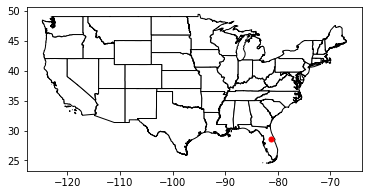

In [79]:
base = states_gdf[~states_gdf.name.isin(clip_list)].plot(color='white', edgecolor='black')
point_gdf.plot(ax=base, marker='o', color='red', markersize=25)